# **1. Import packages**

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [2]:
print(f"Available number of GPU: ", len(tf.config.list_physical_devices('GPU')))

Available number of GPU:  1


# **2. Data Preprocessing and Data Augmentation**

In [4]:
trainingDir = 'images/training'
validationDir = 'images/validation'
testDir = 'images/testing'

In [5]:
# defining constants
batch_size = 8
sizeTarget = (224, 224)

In [6]:
# Augmentation configuration for training
training_imgDataGen = ImageDataGenerator(
        rotation_range=20,
        rescale=1/255,
        horizontal_flip=True)

# Generate batches of augmented image data for training
genTrain = training_imgDataGen.flow_from_directory(
        trainingDir,
        target_size=sizeTarget,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

# Augmentation configuration for validation
val_imgDataGen = ImageDataGenerator(rescale=1/255)

# Generate batches of augmented image data for validation
genVal = val_imgDataGen.flow_from_directory(
            directory=validationDir,
            target_size=sizeTarget,
            shuffle=False,
            class_mode='binary')

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [7]:
# # display training images with respective class
# batchImg = genTrain[0]
# fig, ax = plt.subplots(ncols=8, figsize=(10,10))
# for idx, img in enumerate(batchImg[0][:8]):
#     img = batchImg[0][idx]
#     ax[idx].imshow(img)
#     lab = batchImg[1][idx]
#     ax[idx].title.set_text(lab)

# **3. Build Convolutional Neural Network**

In [8]:
from keras.constraints import max_norm

norm = max_norm(3.0)

# Creating a model
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [224, 224, 3]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, (2, 2), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation ='sigmoid')
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [10]:
# show the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 16)        4112      
                                                                 
 flatten (Flatten)           (None, 46656)             0

In [11]:
# creating callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

# **4. Training Convolutional Neural Network**

In [12]:
# training
history = model.fit(genTrain, epochs=20, validation_data=genVal, callbacks=callback)

Epoch 1/20
25/25 [==============================] - 13s 336ms/step - loss: 1.2588 - accuracy: 0.5100 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 2/20
25/25 [==============================] - 5s 202ms/step - loss: 0.6936 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 0.4800
Epoch 3/20
25/25 [==============================] - 5s 206ms/step - loss: 0.6931 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5400
Epoch 4/20
25/25 [==============================] - 5s 201ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5800
Epoch 5/20
25/25 [==============================] - 5s 205ms/step - loss: 0.6373 - accuracy: 0.6100 - val_loss: 0.7406 - val_accuracy: 0.5800
Epoch 6/20
25/25 [==============================] - 5s 209ms/step - loss: 0.5844 - accuracy: 0.7150 - val_loss: 0.6863 - val_accuracy: 0.6400
Epoch 7/20
25/25 [==============================] - 5s 205ms/step - loss: 0.5421 - accuracy: 0.7400 - val_loss: 0.6160 - val_accuracy: 0.7000
Epoch

# **5. Evaluation**

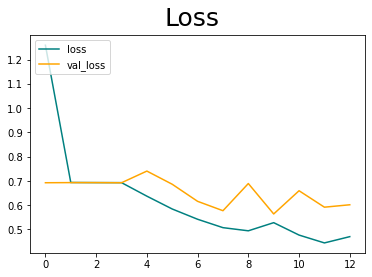

In [13]:
# display loss & val_loss graph
figure1 = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
figure1.suptitle('Loss', fontsize=25)
plt.legend(loc="upper left")
plt.show()

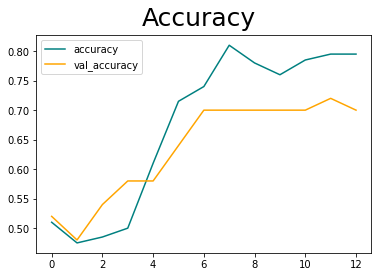

In [14]:
# display accuracy & val_accuracy graph
figure2 = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
figure2.suptitle('Accuracy', fontsize=25)
plt.legend(loc="upper left")
plt.show()

# **6. Saving the model**

In [15]:
# save the model
model.save(os.path.join("models/myModel.h5"))

# **7. Testing**

### **7.1. Testing with Geralt image**

In [16]:
from tensorflow.keras.models import load_model
# loading the model
thisModel = load_model('models/myModel.h5')

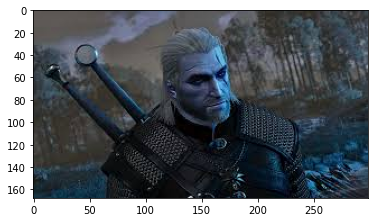

In [17]:
imagePath1 = testDir + "/" + "images189.jpg"
img = cv2.imread(imagePath1)
plt.imshow(img)
plt.show()

In [18]:
img = tf.keras.utils.load_img(
    imagePath1, target_size=sizeTarget
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = thisModel.predict(img_array)

if predictions > 0.5: 
    print(f'Most likely the person on the image is Geralt')
else:
    print(f'Most likely the person on the image is Ciri')

Most likely the person on the image is Geralt


### **7.2. Testing with Ciri image**

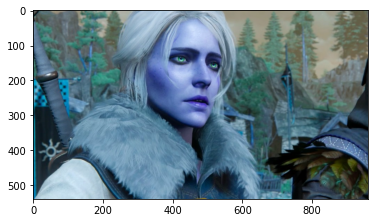

In [19]:
imagePath1 = testDir + "/" + "The-Witcher-4-Das-Medaillon-aus-dem-Teaser-und-was.jpg"
img = cv2.imread(imagePath1)
plt.imshow(img)
plt.show()

In [20]:
img = tf.keras.utils.load_img(
    imagePath1, target_size=sizeTarget
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = thisModel.predict(img_array)

In [21]:
if predictions > 0.5: 
    print(f'Most likely the person on the image is Geralt')
else:
    print(f'Most likely the person on the image is Ciri')

Most likely the person on the image is Ciri
